# Editing State and Human Feedback - Exercise Notebook

## Objectives
Test your understanding of editing LangGraph state and incorporating human feedback by completing the exercises below.

## What You Should Know
- How to use `graph.update_state()` to modify graph state during breakpoints
- How message reducers work (especially `add_messages`)
- How to overwrite vs. append messages using message IDs
- How to create human feedback nodes with `interrupt_before`
- How to use `as_node` parameter in state updates

## Setup

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from IPython.display import Image, display


## Exercise 1: Basic State Editing

Create a simple agent and practice editing its state during a breakpoint.

**Your Task:**
1. Create an agent with tools (calculator functions)
2. Set a breakpoint before the assistant node
3. Run the agent and edit the user's message before the assistant processes it

Graph created successfully!


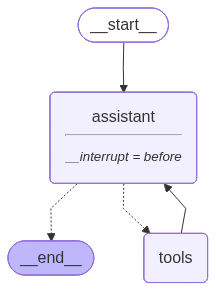

In [2]:
# Define basic calculator tools
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a by b."""
    return a / b

# TODO: Set up your LLM and tools
tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant that performs arithmetic calculations.")

# TODO: Define assistant node
def assistant(state: MessagesState):

    result = llm.invoke(state['messages'])
    return {'messages': [result]}

# TODO: Build graph with breakpoint before assistant
builder = StateGraph(MessagesState)
# Add your nodes and edges
builder.add_node('tools', ToolNode(tools=tools))
builder.add_node('assistant', assistant)
builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', tools_condition)
builder.add_edge('tools', 'assistant')

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=['assistant'])  # Replace with your compiled graph

print("Graph created successfully!")
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Exercise 2: Message Editing with IDs

Practice the difference between appending new messages vs. overwriting existing ones.

In [ ]:
# Test the graph and state editing
initial_input = {"messages": [HumanMessage(content="Calculate 2 + 2")]}
thread = {"configurable": {"thread_id": "edit_test"}}

# TODO: Run until breakpoint
print("Running until breakpoint...")
# Add your code here

# TODO: Get current state and examine the messages
state = None  # Replace with actual state
print("Current messages:")
# Print the current messages

# TODO: Append a new message (without ID)
print("\nAppending new message...")
# Add code to append a new message

# TODO: Show messages after append
print("Messages after append:")

# TODO: Now overwrite the original message (using its ID)
print("\nOverwriting original message...")
# Add code to overwrite the first message using its ID

# TODO: Show final messages
print("Messages after overwrite:")

## Exercise 3: Human Feedback Loop

Create a graph with a dedicated human feedback node that allows for user input.

Feedback graph created!


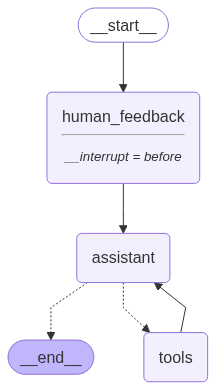

In [11]:
# TODO: Create a no-op human feedback node
def human_feedback(state: MessagesState):
    # This is a placeholder - the actual feedback comes via update_state
    pass

# TODO: Build graph with human feedback node
# Structure: START -> human_feedback -> assistant -> tools -> human_feedback (loop)
feedback_builder = StateGraph(MessagesState)
# Add your nodes and edges with human_feedback integrated

feedback_builder.add_node('assistant', assistant)
feedback_builder.add_node('tools', ToolNode(tools=tools))
feedback_builder.add_node('human_feedback', human_feedback)
feedback_builder.add_edge(START, 'human_feedback')
feedback_builder.add_edge('human_feedback', 'assistant')
feedback_builder.add_conditional_edges('assistant', tools_condition)
feedback_builder.add_edge('tools', 'assistant')

feedback_graph = feedback_builder.compile(checkpointer=memory, interrupt_before=['human_feedback'])  # Replace with compiled graph

print("Feedback graph created!")
display(Image(feedback_graph.get_graph(xray=True).draw_mermaid_png()))

## Exercise 4: Interactive Feedback Session

Simulate an interactive session where human feedback is incorporated multiple times.

In [ ]:
# TODO: Create an interactive feedback function
def run_interactive_session(graph, initial_input, thread_config):
    """
    Run an interactive session with multiple feedback opportunities
    """
    print("Starting interactive session...")
    
    # TODO: Implement the interactive loop
    # 1. Run until first breakpoint
    # 2. Simulate getting user feedback
    # 3. Update state with feedback
    # 4. Continue execution
    # 5. Repeat as needed

    # event is the graph state
    # you will need a checkpointer if you supply thread
    for event in graph.stream(initial_input, thread_config, stream_mode='values'):
        event['messages'][-1].pretty_print() # print the last message
    
    # For simulation, you can use predefined feedback responses
    feedback_responses = [
        "Actually, calculate 5 * 6 instead",
        "Perfect! Now add 10 to that result",
        "Great job!"
    ]
    
    feedback_index = 0
    
    try:
        user_message = 'What is 3+3?'
        graph.update_state(thread_config, {'messages': [HumanMessage(content=user_message)]}, as_node='human_feedback')

        # continue execution
        for event in graph.stream(None, thread_config, stream_mode='values'):
            event['messages'][-1].pretty_print()
            # print(graph.get_state(thread_config))


        # even when the graph reaches its end, because it has a checkpointer, next when it is invoke the whole
        # previous history will be added to th state

        for resp in feedback_responses:
            graph.update_state(thread_config, {'messages': [HumanMessage(content=resp)]}, as_node='human_feedback')

            for event in graph.stream(None, thread_config, stream_mode='values'):
                event['messages'][-1].pretty_print()
                history = graph.get_state(thread_config).values['messages']
                for h in history:
                    print(h)
        
    except Exception as e:
        print(f"Session ended: {e}")

# Test the interactive session
test_input = {"messages": [HumanMessage(content="Help me with some math")]}
test_thread = {"configurable": {"thread_id": "interactive_test"}}

# memory = MemorySaver()
# if we use the same thread id, without re-initiating the memorysaver the previous conversion is alwasy reloaded in full 
feedback_graph = feedback_builder.compile(checkpointer=memory, interrupt_before=['human_feedback'])  # Replace with compiled graph

# TODO: Run your interactive session
run_interactive_session(feedback_graph, test_input, test_thread)

Starting interactive session...
================================ Human Message =================================

Help me with some math
================================ Human Message =================================

What is 3+3?
================================== Ai Message ==================================

3 + 3 equals 6.
================================ Human Message =================================

Actually, calculate 5 * 6 instead
content='Help me with some math' additional_kwargs={} response_metadata={} id='dcca6334-b226-491f-9b24-d9d2f45bf1c6'
content='What is 3+3?' additional_kwargs={} response_metadata={} id='84a3faf9-79ab-4a61-ad95-e3a7a41354ca'
content='3 + 3 equals 6.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 23, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'au

## Exercise 5: Advanced State Manipulation

Practice more complex state editing scenarios including conditional updates.

In [ ]:
from typing_extensions import TypedDict

# Extended state for more complex scenarios
class ExtendedState(MessagesState):
    user_preferences: dict
    conversation_context: str
    approval_needed: bool

def smart_assistant(state: ExtendedState):
    """
    Assistant that considers user preferences and context
    """
    # TODO: Implement assistant that uses the extended state
    pass

def context_analyzer(state: ExtendedState):
    """
    Analyze conversation and update context/preferences
    """
    # TODO: Implement context analysis
    pass

def approval_gate(state: ExtendedState):
    """
    Determine if human approval is needed
    """
    # TODO: Implement approval logic
    pass

# TODO: Build extended graph with conditional flows
extended_builder = StateGraph(ExtendedState)
# Add nodes and conditional edges based on approval_needed

extended_graph = None  # Replace with compiled graph

# Test scenarios
test_scenarios = [
    {
        "messages": [HumanMessage(content="I prefer detailed explanations. Calculate 15 * 23")],
        "user_preferences": {"detail_level": "high", "format": "step-by-step"},
        "conversation_context": "mathematics tutoring",
        "approval_needed": False
    },
    # TODO: Add more test scenarios with different approval requirements
]

# TODO: Test each scenario with appropriate state updates

## Exercise 6: State Update Strategies

Explore different strategies for updating state and their effects.

In [ ]:
def demonstrate_update_strategies():
    """
    Demonstrate different state update strategies
    """
    # TODO: Create a simple graph for testing
    
    # Strategy 1: Simple message replacement
    print("=== Strategy 1: Message Replacement ===")
    # TODO: Demonstrate replacing a message by ID
    
    # Strategy 2: Adding context through new messages
    print("\n=== Strategy 2: Context Addition ===")
    # TODO: Demonstrate adding context messages
    
    # Strategy 3: Conditional updates with as_node
    print("\n=== Strategy 3: as_node Updates ===")
    # TODO: Demonstrate using as_node parameter
    
    # Strategy 4: Batch updates
    print("\n=== Strategy 4: Batch Updates ===")
    # TODO: Demonstrate updating multiple state fields at once

# TODO: Run the demonstration

## Exercise 7: Error Recovery with State Editing

Use state editing to recover from errors and guide the conversation back on track.

In [ ]:
def error_recovery_assistant(state: MessagesState):
    """
    Assistant that might encounter errors
    """
    try:
        # TODO: Implement assistant that might fail on certain inputs
        # For example, fail on requests for information it doesn't have
        messages = state["messages"]
        last_message = messages[-1].content.lower()
        
        if "weather" in last_message:
            # Simulate an error - we don't have weather data
            raise ValueError("Weather information not available")
        
        # Normal processing for other requests
        response = llm_with_tools.invoke([sys_msg] + messages)
        return {"messages": [response]}
        
    except Exception as e:
        # Return error state that can be handled by human feedback
        error_msg = AIMessage(content=f"Error occurred: {e}. Human intervention needed.")
        return {"messages": [error_msg]}

def error_handler(graph, initial_input, thread_config):
    """
    Handle errors through state editing and human feedback
    """
    # TODO: Implement error handling workflow
    # 1. Run the graph
    # 2. Check for error messages
    # 3. If error found, update state with corrected input
    # 4. Retry execution
    pass

# TODO: Test error recovery with various error-inducing inputs
error_test_cases = [
    "What's the weather like?",  # Should cause error
    "Calculate 10 + 5",          # Should work normally
    "Tell me about the stock market",  # Might cause error
]

# TODO: Test each case with error recovery

## Reflection Questions

Answer these questions to test your understanding:

1. **What's the difference between updating state with and without a message ID?**
   - Your answer: 

2. **When would you use the `as_node` parameter in `update_state`?**
   - Your answer: 

3. **How do message reducers like `add_messages` affect state updates?**
   - Your answer: 

4. **What are some practical use cases for editing state during breakpoints?**
   - Your answer: 

5. **How can state editing be used for error recovery and conversation repair?**
   - Your answer: 

## Challenge: Intelligent Conversation Manager

**Advanced Exercise:** Create an intelligent conversation manager that:
- Tracks conversation quality and coherence
- Automatically suggests corrections when conversations go off-track
- Maintains conversation history and learns from user feedback
- Provides multiple options for state correction when issues are detected
- Implements conversation rollback and replay functionality

In [ ]:
class ConversationState(MessagesState):
    conversation_quality: float
    topic_coherence: float
    user_satisfaction: float
    correction_suggestions: list
    conversation_checkpoints: list

class ConversationManager:
    def __init__(self):
        self.quality_threshold = 0.7
        self.coherence_threshold = 0.6
    
    def analyze_conversation_quality(self, state: ConversationState) -> float:
        """
        Analyze the quality of the current conversation
        """
        # TODO: Implement conversation quality analysis
        pass
    
    def suggest_corrections(self, state: ConversationState) -> list:
        """
        Suggest ways to improve the conversation
        """
        # TODO: Implement correction suggestions
        pass
    
    def create_checkpoint(self, state: ConversationState) -> dict:
        """
        Create a conversation checkpoint for potential rollback
        """
        # TODO: Implement checkpoint creation
        pass

# TODO: Implement the full conversation management system
# Consider:
# - Real-time quality monitoring
# - Proactive intervention suggestions
# - User preference learning
# - Conversation analytics and reporting